In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

import joblib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

df = pd.read_csv("../data/spot_5min_features_with_regime.csv", parse_dates=["Datetime"])
trades_df = pd.read_csv("../results/trades.csv", parse_dates=["entry_time", "exit_time"])

print(df.shape, trades_df.shape)
df.head(), trades_df.head()

(3047, 25) (14, 5)


(   index                  Datetime        open        high         low  \
 0      0 2025-11-18 05:55:00+00:00  293.299988  293.299988  293.089996   
 1      1 2025-11-18 06:00:00+00:00  293.079987  293.200012  293.000000   
 2      2 2025-11-18 06:05:00+00:00  293.200012  293.299988  293.130005   
 3      3 2025-11-18 06:10:00+00:00  293.269989  293.410004  293.230011   
 4      4 2025-11-18 06:15:00+00:00  293.429993  293.589996  293.339996   
 
         close    volume     ret_1     ret_5      ema_20  ...  volume_z  \
 0  293.089996  122093.0 -0.000784 -0.000205  293.092066  ...  1.292831   
 1  293.149994   25759.0  0.000205  0.000171  293.097583  ... -0.600434   
 2  293.269989   22863.0  0.000409  0.000307  293.114002  ... -0.666646   
 3  293.329987   23578.0  0.000205  0.000341  293.134572  ... -0.663005   
 4  293.450012   37559.0  0.000409  0.000443  293.164614  ... -0.393213   
 
    sentiment_pressure  future_price   basis  delta_proxy  gamma_proxy  \
 0            0.000926

In [2]:
df_feat = df.set_index("Datetime")

rows = []

for _, trade in trades_df.iterrows():
    t = trade["entry_time"]
    if t not in df_feat.index:
        continue

    row = df_feat.loc[t].copy()
    row["target"] = 1 if trade["pnl"] > 0 else 0
    row["pnl"] = trade["pnl"]
    row["entry_time"] = t

    rows.append(row)

ml_df = pd.DataFrame(rows)

print("ML dataset shape:", ml_df.shape)
print("Target distribution:")
print(ml_df["target"].value_counts())
ml_df.head()


ML dataset shape: (14, 27)
Target distribution:
target
0    10
1     4
Name: count, dtype: int64


,index,open,high,low,close,volume,ret_1,ret_5,ema_20,ema_50,...,basis,delta_proxy,gamma_proxy,vega_proxy,theta_proxy,regime,regime_name,target,pnl,entry_time
2025-11-18 06:05:00+00:00,2,293.200012,293.299988,293.130005,293.269989,22863.0,0.000409,0.000307,293.114002,293.283907,...,0.0001,-0.169905,0.016988,-0.000087,-0.000413,2,Uptrend,0,-0.002387,2025-11-18 06:05:00+00:00
2025-12-10 05:30:00+00:00,1195,292.369995,292.589996,292.049988,292.579987,147248.0,0.000718,-0.002489,292.920354,292.821962,...,0.0001,0.098391,-0.025952,-0.000045,-0.000608,1,Sideways,0,-0.000103,2025-12-10 05:30:00+00:00
2025-12-10 08:00:00+00:00,1225,292.440002,292.470001,292.369995,292.390015,27857.0,-0.000205,0.001301,292.235068,292.404669,...,0.0001,-0.169601,0.016908,-0.000017,-0.000480,2,Uptrend,0,-0.004240,2025-12-10 08:00:00+00:00
2025-12-11 04:15:00+00:00,1255,291.089996,291.390015,290.859985,291.390015,69778.0,0.000893,-0.001371,291.627842,291.880506,...,0.0001,-0.252664,-0.005014,0.000265,-0.000858,2,Uptrend,0,-0.003126,2025-12-11 04:15:00+00:00
2025-12-11 04:50:00+00:00,1262,292.190002,292.200012,291.880005,292.179993,93459.0,-0.000034,0.003883,291.690981,291.837476,...,0.0001,-0.146495,0.037495,0.000249,-0.000868,2,Uptrend,1,0.005168,2025-12-11 04:50:00+00:00


In [3]:
feature_cols = [
    "ret_1", "ret_5",
    "volatility_20", "volatility_100",
    "ema_diff",
    "hl_range",
    "volume_z",
    "sentiment_pressure",
    "basis",
    "delta_proxy", "gamma_proxy", "vega_proxy", "theta_proxy",
    "regime"
]

ml_df["hour"] = ml_df["entry_time"].dt.hour
ml_df["minute"] = ml_df["entry_time"].dt.minute

feature_cols = feature_cols + ["hour", "minute"]

ml_df = ml_df.dropna(subset=feature_cols + ["target"])

X = ml_df[feature_cols]
y = ml_df["target"]

print(X.shape, y.shape)

(14, 16) (14,)


In [4]:
split = int(len(X) * 0.7)

X_train = X.iloc[:split]
X_test  = X.iloc[split:]

y_train = y.iloc[:split]
y_test  = y.iloc[split:]

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (9, 16) Test: (5, 16)


In [5]:
model_gb = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    random_state=42
)

model_gb.fit(X_train, y_train)

y_pred = model_gb.predict(X_test)
y_prob = model_gb.predict_proba(X_test)[:,1]

print("Gradient Boosting Results:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


Gradient Boosting Results:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.50      1.00      0.67         1

    accuracy                           0.80         5
   macro avg       0.75      0.88      0.76         5
weighted avg       0.90      0.80      0.82         5

ROC AUC: 0.875


In [6]:
joblib.dump(model_gb, "../models/trade_filter_gb.pkl")
print("Saved Gradient Boosting model.")

Saved Gradient Boosting model.


In [8]:
df["Datetime"] = pd.to_datetime(df["Datetime"])
df["hour"] = df["Datetime"].dt.hour
df["minute"] = df["Datetime"].dt.minute
df["dayofweek"] = df["Datetime"].dt.dayofweek

In [9]:
feature_cols = [
    "ret_1", "ret_5", "ema_diff", "volatility_20", "volatility_100",
    "hl_range", "volume_z", "sentiment_pressure", "basis",
    "delta_proxy", "gamma_proxy", "vega_proxy", "theta_proxy",
    "hour", "minute", "dayofweek"
]

In [10]:
SEQ_LEN = 10
seq_features = feature_cols.copy()
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[seq_features] = scaler.fit_transform(df_scaled[seq_features])
df_scaled = df_scaled.set_index("Datetime")
X_seq = []
y_seq = []

for _, trade in ml_df.iterrows():
    t = trade["entry_time"]
    if t not in df_scaled.index:
        continue
    idx = df_scaled.index.get_loc(t)
    if idx < SEQ_LEN:
        continue
    seq = df_scaled.iloc[idx-SEQ_LEN:idx][seq_features].values
    X_seq.append(seq)
    y_seq.append(trade["target"])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
print("LSTM sequences:", X_seq.shape, y_seq.shape)

LSTM sequences: (13, 10, 16) (13,)


In [11]:
split_seq = int(len(X_seq) * 0.7)

X_seq_train = X_seq[:split_seq]
X_seq_test  = X_seq[split_seq:]

y_seq_train = y_seq[:split_seq]
y_seq_test  = y_seq[split_seq:]

print(X_seq_train.shape, X_seq_test.shape)

(9, 10, 16) (4, 10, 16)


In [12]:
model_lstm = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, X_seq.shape[2])),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model_lstm.compile(
    optimizer=Adam(0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model_lstm.fit(
    X_seq_train, y_seq_train,
    epochs=30,
    batch_size=8,
    validation_data=(X_seq_test, y_seq_test),
    verbose=1
)

c:\Users\laksh\OneDrive\Desktop\quant-task\quant_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 762ms/step - accuracy: 0.6667 - loss: 0.6095 - val_accuracy: 0.2500 - val_loss: 0.7782
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.4444 - loss: 0.7166 - val_accuracy: 0.2500 - val_loss: 0.7784
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5556 - loss: 0.6644 - val_accuracy: 0.2500 - val_loss: 0.7767
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5556 - loss: 0.6176 - val_accuracy: 0.5000 - val_loss: 0.7720
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.6667 - loss: 0.5373 - val_accuracy: 0.5000 - val_loss: 0.7698
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6667 - loss: 0.5674 - val_accuracy: 0.7500 - val_loss: 0.7663
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.5556 - loss: 0.5635 - val_accuracy: 0.7500 - val_loss: 0.7658
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5556 - loss: 0.4961 - val_accuracy: 0.7500 - val_loss

In [15]:
model_lstm.save("../models/lstm_model.keras")
print("Saved LSTM model.")

Saved LSTM model.


In [16]:
ml_df["gb_prob"] = model_gb.predict_proba(X)[:,1]

ml_df_lstm = ml_df.iloc[:len(X_seq)].copy()
ml_df_lstm["lstm_prob"] = model_lstm.predict(X_seq).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


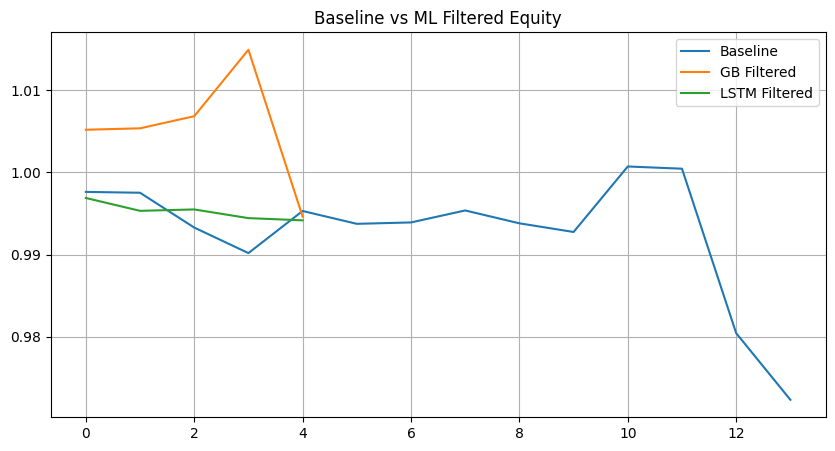

In [22]:
baseline_eq = (1 + ml_df["pnl"]).cumprod()

gb_filtered = ml_df[ml_df["gb_prob"] > 0.5]
gb_eq = (1 + gb_filtered["pnl"]).cumprod()

lstm_filtered = ml_df_lstm[ml_df_lstm["lstm_prob"] > 0.5]
lstm_eq = (1 + lstm_filtered["pnl"]).cumprod()

plt.figure(figsize=(10,5))
plt.plot(baseline_eq.values, label="Baseline")
plt.plot(gb_eq.values, label="GB Filtered")
plt.plot(lstm_eq.values, label="LSTM Filtered")

plt.title("Baseline vs ML Filtered Equity")
plt.legend()
plt.grid(True)
plt.savefig("../plots/equity_baseline_vs_ml.png",dpi=200,bbox_inches="tight")
plt.show()

In [19]:
ml_df.to_csv("../results/data_with_ml_predictions.csv", index=False)
print("Saved data_with_ml_predictions.csv")

Saved data_with_ml_predictions.csv


In [21]:
ml_df_lstm.to_csv("../results/data_with_ml_predictions_lstm.csv", index=False)
print("Saved data_with_ml_predictions_lstm.csv")

Saved data_with_ml_predictions_lstm.csv
